# Automated DFT

This lesson focuses on key concepts necessary to run automated Density Functional Theory (DFT) workflows using our atomate code. We begin by focusing on using pymatgen to build inputs and parsing outputs of DFT calculations. We then build an understanding of `InputSets` in pymatgen, a key capability to automate running DFT. We finally go through a demonstration of using atomate.


## Core Concepts
- **Input/Output** - There is an enitre module in pymatgen devoted to reading and writing the input and output files of other codes
- **Input Sets** - Standardizing the input options to various codes allows for repeatability and automatically generitng inputs for a new calculation
- **Atomate** - This is a set of automated recipes for computing materials and molecular properties using density functional theory

## Lesson 1: Using Pymatgen IO

For the first lesson we'll focus on using pymatgen to interface with DFT codes in the most simple way possible. Pymatgen has a IO module which is designed to have methods to parse and write files that are compatible with a number of external codes. These include:

- AbInit
- EXCITING
- FEFF
- LAMMPS
- Lobster
- QChem
- VASP
- ATAT
- Gaussian
- NWCHem
- ShengBTE
- Wannier90
- Zeo++

For the purpose of this tutorial, we'll focus on using VASP and QChem as these are the primary DFT codes used by the Materials Project.

### VASP Inputs
Let's beging by reading some VASP inputs for an Al-Cr alloy structure:

In [1]:
from pymatgen import Structure
struc = Structure.from_file("Al16Cr10.cif")

This is a CIF file which is not compatible with many DFT codes. Each code has its own input structure. Next, we'll make a POSCAR file which is the way structures are represented in VASP

In [2]:
from pymatgen.io.vasp.inputs import Poscar

poscar = Poscar(structure=struc)
print(poscar)

Al16 Cr10
1.0
7.417988 0.000000 -2.655322
-3.770804 6.388081 -2.655321
0.000000 0.000000 7.878914
Al Cr
16 10
direct
0.696455 0.696455 0.696455 Al
0.646563 0.002044 0.646563 Al
0.646563 0.646563 0.002044 Al
0.002044 0.646563 0.646563 Al
0.336523 0.558569 0.336523 Al
0.336523 0.336523 0.558569 Al
0.558569 0.336523 0.336523 Al
0.734771 0.383622 0.734771 Al
0.734771 0.734771 0.383622 Al
0.383622 0.734771 0.734771 Al
0.280797 0.666745 0.038053 Al
0.038053 0.280797 0.666745 Al
0.666745 0.038053 0.280797 Al
0.666745 0.280797 0.038053 Al
0.038053 0.666745 0.280797 Al
0.280797 0.038053 0.666745 Al
0.151124 0.151124 0.151124 Cr
0.015343 0.797266 0.015343 Cr
0.015343 0.015343 0.797266 Cr
0.797266 0.015343 0.015343 Cr
0.987828 0.333690 0.987828 Cr
0.987828 0.987828 0.333690 Cr
0.333690 0.987828 0.987828 Cr
0.365023 0.015932 0.365023 Cr
0.365023 0.365023 0.015932 Cr
0.015932 0.365023 0.365023 Cr



Note that this POSCAR object has a method that lets you write it out as a file. This makes it very easy to construct complex structures such as heterostructures or adsorbates on surfaces and write them out to compute using a DFT code like VASP.

For the purpose of this example, we've provided a completed VASP calculation under `VASP_Al16Cr10_example`. Let's use pymatgen to read the inputs in this directory

In [3]:
poscar = Poscar.from_file("./VASP_Al16Cr10_example//POSCAR.gz")
print(poscar)

Al16 Cr10
1.0
7.430657 -0.067234 -2.618797
-3.680038 6.455734 -2.618797
-0.039473 -0.067234 7.878528
Al Cr
16 10
direct
0.696455 0.696455 0.696455 Al
0.646563 0.002044 0.646563 Al
0.646563 0.646563 0.002044 Al
0.002044 0.646563 0.646563 Al
0.336523 0.558569 0.336523 Al
0.336523 0.336523 0.558569 Al
0.558569 0.336523 0.336523 Al
0.734771 0.383622 0.734771 Al
0.734771 0.734771 0.383622 Al
0.383622 0.734771 0.734771 Al
0.280797 0.666745 0.038053 Al
0.038053 0.280797 0.666745 Al
0.666745 0.038053 0.280797 Al
0.666745 0.280797 0.038053 Al
0.038053 0.666745 0.280797 Al
0.280797 0.038053 0.666745 Al
0.151124 0.151124 0.151124 Cr
0.015343 0.797266 0.015343 Cr
0.015343 0.015343 0.797266 Cr
0.797266 0.015343 0.015343 Cr
0.987828 0.333690 0.987828 Cr
0.987828 0.987828 0.333690 Cr
0.333690 0.987828 0.987828 Cr
0.365023 0.015932 0.365023 Cr
0.365023 0.365023 0.015932 Cr
0.015932 0.365023 0.365023 Cr



/Users/shyamd/Dropbox/Codes/pymatgen/pymatgen/io/vasp/inputs.py:1853: UnknownPotcarWarning: POTCAR with symbol Al has metadata that does not match                          any VASP POTCAR known to pymatgen. The data in this                          POTCAR is known to match the following functionals:                          ['PBE']
  warnings.warn("POTCAR with symbol {} has metadata that does not match\
/Users/shyamd/Dropbox/Codes/pymatgen/pymatgen/io/vasp/inputs.py:1853: UnknownPotcarWarning: POTCAR with symbol Cr_pv has metadata that does not match                          any VASP POTCAR known to pymatgen. The data in this                          POTCAR is known to match the following functionals:                          ['PBE']
  warnings.warn("POTCAR with symbol {} has metadata that does not match\


In this POSCAR object there is a full pymatgen Structure we can grab and use pythonically if we have a manipulation we want to apply. 

In [4]:
poscar.structure

Structure Summary
Lattice
    abc : 7.878913731575819 7.87891356009247 7.878913756049688
 angles : 109.69518778724337 109.69519443176932 109.69518691661757
 volume : 373.35579693687976
      A : 7.430657 -0.067234 -2.618797
      B : -3.680038 6.455734 -2.618797
      C : -0.039473 -0.067234 7.878528
PeriodicSite: Al (2.5846, 4.4025, 1.8393) [0.6965, 0.6965, 0.6965]
PeriodicSite: Al (4.7713, -0.0737, 3.3954) [0.6466, 0.0020, 0.6466]
PeriodicSite: Al (2.4249, 4.1304, -3.3703) [0.6466, 0.6466, 0.0020]
PeriodicSite: Al (-2.3897, 4.1304, 3.3954) [0.0020, 0.6466, 0.6466]
PeriodicSite: Al (0.4317, 3.5607, 0.3072) [0.3365, 0.5586, 0.3365]
PeriodicSite: Al (1.2401, 2.1123, 2.6381) [0.3365, 0.3365, 0.5586]
PeriodicSite: Al (2.8988, 2.1123, 0.3072) [0.5586, 0.3365, 0.3365]
PeriodicSite: Al (4.0191, 2.3778, 2.8601) [0.7348, 0.3836, 0.7348]
PeriodicSite: Al (2.7407, 4.6683, -0.8261) [0.7348, 0.7348, 0.3836]
PeriodicSite: Al (0.1176, 4.6683, 2.8601) [0.3836, 0.7348, 0.7348]
PeriodicSite: Al (-0.368

VASP has three other primary input files: KPOINTS, POTCAR, and INCAR. Each of these has a corresponding object. Each of these can read and write the corresponding VASP Files. Let's read the inputs in the `Al16Cr10_VASP` directory included in this lesson. Let's look at the POTCAR file next.

In [5]:
from pymatgen.io.vasp.inputs import Potcar

al_cr_potcar = Potcar.from_file("./VASP_Al16Cr10_example/POTCAR.gz")
print(al_cr_potcar.symbols)

['Al', 'Cr_pv']


Note the above warning suggesting something is wrong with these POTCARs. We maintain a list of hashes of VASP POTCARs to ensure the data is not corrupted when VASP is run.  For the purpose of this lesson, we've included fake POTCARs as the offical POTCARs are licensed by VASP. You can always check the hash of your own POTCARs by investigating the `spec` of the Potcar object.

In [6]:
print(al_cr_potcar.spec)

[{'symbol': 'Al', 'hash': 'a6fd9a46aec185f4ad2acd0cbe4ae2fa'}, {'symbol': 'Cr_pv', 'hash': 'eb23364cc25164418f9f79efd8f04f7d'}]


### VASP Outputs

Once, you've run VASP, you'll need to parse the VASP outputs to get the data you want. VASP makes a number of output files: 

- WAVECAR
- CHGCAR
- OUTCAR
- vasprun.xml
- PROCAR
- And more ...

Please read the [VASP documentation](https://www.vasp.at/wiki/index.php/The_VASP_Manual) for a good description of what these all are. For this lesson. We'll focus on `vasprun.xml` in the `Al16Cr10_vasp` directory. The Vasprun contains a lot information that can be parsed using the `Vasprun` object in pymatgen

In [7]:
from pymatgen.io.vasp.outputs import Vasprun

vrun = Vasprun(filename="./VASP_Al16Cr10_example/vasprun.xml.gz")

Since VASPRUN has most of the information that VASP can provide, this one object is often enough to parse a full VASP calculation. The various properties available from the VASPRUN are properties in the `Vasprun` object. Use Shift+Tab to look through all the properties and try some out

In [8]:
vrun.vasp_version

'5.4.4.18Apr17-6-g9f103f2a35'

We can see what actual kpoints VASP used when it auto-generated it's mesh to run DFT on:

In [9]:
vrun.actual_kpoints

[[0.0, 0.0, 0.0],
 [0.33333333, -0.0, -0.0],
 [0.0, 0.33333333, 0.0],
 [0.33333333, 0.33333333, 0.0],
 [-0.33333333, 0.33333333, 0.0],
 [0.0, -0.0, 0.33333333],
 [0.33333333, -0.0, 0.33333333],
 [-0.33333333, 0.0, 0.33333333],
 [0.0, 0.33333333, 0.33333333],
 [0.33333333, 0.33333333, 0.33333333],
 [-0.33333333, 0.33333333, 0.33333333],
 [-0.0, -0.33333333, 0.33333333],
 [0.33333333, -0.33333333, 0.33333333],
 [-0.33333333, -0.33333333, 0.33333333]]

We can also look at the final energy

In [10]:
vrun.final_energy

-157.80974238

Or even the progress of VASP as it optimized the structure

In [11]:
len(vrun.ionic_steps)

4

Each ionic step contains the energy, forces, stress, the structure

In [12]:
vrun.ionic_steps[0].keys()

dict_keys(['e_fr_energy', 'e_wo_entrp', 'e_0_energy', 'forces', 'stress', 'electronic_steps', 'structure'])

## Lesson 2: Input Sets

This lesson will focus on using `InputSets`. These are objects that provide default parameters to perform a specific kind of calcualtion. There are several `InputSets` that are default MP parameters, but it's also possible to define your own `InputSet` that lets you build new calculations using the parameters you want. 

Let's begin by taking the Al-Cr structure and making a simple input set to optimize this structure

In [13]:
from pymatgen.io.vasp.sets import MPRelaxSet

relax_set = MPRelaxSet(structure=struc)
print(relax_set.incar)

ALGO = Fast
EDIFF = 0.0013000000000000002
ENCUT = 520
IBRION = 2
ICHARG = 1
ISIF = 3
ISMEAR = -5
ISPIN = 2
LORBIT = 11
LREAL = Auto
LWAVE = False
MAGMOM = 16*0.6 10*5.0
NELM = 100
NSW = 99
PREC = Accurate
SIGMA = 0.05



/Users/shyamd/Dropbox/Codes/pymatgen/pymatgen/io/vasp/sets.py:589: BadInputSetWarning: Relaxation of likely metal with ISMEAR < 1 detected. Please see VASP recommendations on ISMEAR for metals.
  warnings.warn(


We can see that the input set has pre-set values for a number of parameters. Some of these such as `ALGO` and `IBRION` just tell VASP what kind of calculation to perform, but other such as `EDIFF`, `ENCUT,` and `MAGMOM` are structure specific. The `MPRelaxSet`, which is designed to optimize a structure, has default MP parameters that make the resulting structure compataible with MP data. 


Many DFT calculations actually extend from a previous calculation. For instance, it's often desireable to perform a static calculation from a previous relaxation calculation. `InputSet`s for these types of calculations have `classmethod` that lets you automatically construct the next calculation input set from the output of a previous calculation.

In [14]:
from pymatgen.io.vasp.sets import MPStaticSet
static_set = MPStaticSet.from_prev_calc("./VASP_Al16Cr10_example/")

print(static_set.incar)

ALGO = Normal
EDIFF = 0.0013
ENCUT = 520.0
IBRION = -1
ICHARG = 0
ISIF = 3
ISMEAR = -5
ISPIN = 2
KPOINT_BSE = -1 0 0 0
LAECHG = True
LCHARG = True
LORBIT = 11
LREAL = Auto
LVHAR = True
LWAVE = False
MAGMOM = 1*0.013 3*-0.012 3*-0.022 3*-0.01 2*-0.019 1*-0.018 2*-0.019 1*-0.018 1*0.487 1*-0.501 1*-0.505 1*-0.5 1*0.99 1*0.967 1*0.968 1*1.509 1*1.532 1*1.536
NELM = 100
NSW = 0
PREC = accurate
SIGMA = 0.05



Notice how the `MAGMOM` list is very different for this calculation. `MAGMOM` is the set of magnetic moments that VASP is using both as its input and its writing in its output. Because the magnetic moment and the charge density are closely related, the new lowest energy configuration is actually not the nice Ferromagnetic configuration that was put into the initial relaxation calculation but a newer more complex configuration with much lower overall magnetic moment. 


Other inputs are a function of the InputSet is designed to do. The `MPRelaxSet` is designed to be a structure optimization that balances accuracy and computational cost. The `MPstaticSet` on the other hand is designed to increase the accuracy once an optimized structure is found to get a good charge density and DFT energy. The result is that these two sets produce different K-point densities as shown next.

In [15]:
relax_set.kpoints

pymatgen v2020.7.16 with grid density = 1106 / number of atoms
0
Gamma
3 3 3

In [16]:
static_set.kpoints

Automatic kpoint scheme
0
Gamma
4 4 4

### Storing Input Sets

InputSet objects follow the `MSONable` pattern used heavily in pymatgen. This means that an InputSet with a structure or molecules can be converted to a dictionary and then stored in a database, which is very useful for running high throughput calculations or workflows. 

In [17]:
relax_set.as_dict()

{'@module': 'pymatgen.io.vasp.sets',
 '@class': 'MPRelaxSet',
 '@version': '2020.7.16',
 'structure': {'@module': 'pymatgen.core.structure',
  '@class': 'Structure',
  'charge': None,
  'lattice': {'matrix': [[7.4179879378990465, 0.0, -2.6553223002051487],
    [-3.7708043655287886, 6.388081220096888, -2.6553213832427804],
    [0.0, 0.0, 7.87891376]],
   'a': 7.87891373,
   'b': 7.878913559999999,
   'c': 7.87891376,
   'alpha': 109.69518779,
   'beta': 109.69519443,
   'gamma': 109.69518691999998,
   'volume': 373.35579702428646},
  'sites': [{'species': [{'element': 'Al', 'occu': 1.0}],
    'abc': [0.696455, 0.696455, 0.696455],
    'xyz': [2.540099234895128, 4.449011106142579, 1.7886845361650723],
    'label': 'Al',
    'properties': {}},
   {'species': [{'element': 'Al', 'occu': 1.0}],
    'abc': [0.646563, 0.002044, 0.646563],
    'xyz': [4.78848901096868, 0.013057238013878038, 3.37195348811199],
    'label': 'Al',
    'properties': {}},
   {'species': [{'element': 'Al', 'occu': 1.

## Lesson 3: Automating DFT with Atomate

The final section of this lesson focuses on automating DFT using our `atomate` code. `atomate` is a set of recipes for computing properties for both molecules and structures. The workflows in `atomate` run on `fireworks`, our workflow management software. `fireworks` stores workflow information and calculation summaries in MongoDB. Using this infrastructure MP routinely manages 10,000 simultaneous calculations on supercomputers such as Cori at NERSC. 

Let's begin by importing a basic silicon structure

In [18]:
from pymatgen import Structure
si = Structure.from_file("Si.CIF")

Now, we'll make a workflow to optimize our structure

In [19]:
from atomate.vasp.workflows import wf_structure_optimization

In [20]:
wf = wf_structure_optimization(structure=si)
print(wf)

Workflow object: (fw_ids: odict_keys([-1]) , name: Si)


Fireworks doesn't tell us much about the workflow, but we can tell there is only one firework. A firework is a single job for a supercomputer, involving usually just a few DFT calculations. Let's use a more complex example to illustrate how easy this is. Let's compute the full bandstructure for Silicon

In [21]:
from atomate.vasp.workflows import wf_bandstructure

wf = wf_bandstructure(structure=si)
print(wf)

Workflow object: (fw_ids: odict_keys([-2, -3, -4, -5]) , name: Si)


Now we can see there are a low more fireworks in this workflow, but its still hard to tell what is going on. Let's start by looking at the whole workflow as a graph.

We'll use a function built for this workshop to plot what the workflow looks like.

In [22]:
from mp_workshop.atomate import wf_to_graph

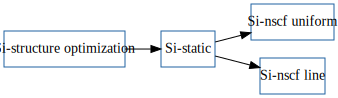

In [23]:
wf_to_graph(wf)

This is clearly a more complex workflow with an intermediate step to compute the full bandstructore of Si both along the special high-symmetry lines in Brillouin zone and with a uniform grid.


To make this workshop more usefull, we've provided a set of fake VASP input and outputs and a helper function that will let atomate "run" these calculations. In reality, these take a lot more CPU time and a License to VASP, which we can't provide in this workshop. Let's use that fake VASP utility to "run" this workflow.

In [24]:
from mp_workshop.atomate import use_fake_vasp_workshop

Now lets run the above workflow. First we have to add this to our LaunchPad. Fireworks hides the database with an object called a LaunchPad. This allows you to submit and query workflows from anywhere you have database access. We need to get ourselves a LaunchPad object so we can submit our workflow

In [25]:
from fireworks import LaunchPad

In [26]:
lp = LaunchPad.auto_load()

For this one time, we have to initialize the database. In everyday use, we'll only need to do this once, upon database creation.

In [27]:
lp.reset(password=None,require_password=False)

2020-07-29 16:22:52,820 INFO Performing db tune-up
2020-07-29 16:22:52,917 INFO LaunchPad was RESET.


In [28]:
wf = use_fake_vasp_workshop(wf)
lp.add_wf(wf)

2020-07-29 16:22:52,930 INFO Added a workflow. id_map: {-5: 1, -4: 2, -3: 3, -2: 4}


{-5: 1, -4: 2, -3: 3, -2: 4}

Now let's see what the status of our workflow is in the LaunchPad

In [29]:
lp.get_wf_summary_dict(1)

{'state': 'READY',
 'name': 'Si',
 'created_on': datetime.datetime(2020, 7, 29, 23, 22, 52, 542000),
 'updated_on': datetime.datetime(2020, 7, 29, 23, 22, 52, 542000),
 'states': OrderedDict([('Si-nscf line--1', 'WAITING'),
              ('Si-nscf uniform--2', 'WAITING'),
              ('Si-static--3', 'WAITING'),
              ('Si-structure optimization--4', 'READY')]),
 'launch_dirs': OrderedDict([('Si-nscf line--1', []),
              ('Si-nscf uniform--2', []),
              ('Si-static--3', []),
              ('Si-structure optimization--4', [])])}

Normally we don't run these calculation in a notebook, but rather on a supercomputer. We use a command called `qlaunch` to automatically submit to the supercomputer to run. We can also run them locally using the command `rlaunch`. Let's check how we'd use it.

In [30]:
!rlaunch --help

FW Echo Test: MP Workshop
usage: rlaunch [-h] [-l LAUNCHPAD_FILE] [-w FWORKER_FILE] [-c CONFIG_DIR]
               [--loglvl LOGLVL] [-s]
               {singleshot,rapidfire,multi} ...

This program launches one or more Rockets. A Rocket retrieves a job from the
central database and runs it. The "single-shot" option launches a single
Rocket, whereas the "rapidfire" option loops until all FireWorks are
completed.

positional arguments:
  {singleshot,rapidfire,multi}
                        command
    singleshot          launch a single Rocket
    rapidfire           launch multiple Rockets (loop until all FireWorks
                        complete)
    multi               launches multiple Rockets simultaneously

optional arguments:
  -h, --help            show this help message and exit
  -l LAUNCHPAD_FILE, --launchpad_file LAUNCHPAD_FILE
                        path to launchpad file
  -w FWORKER_FILE, --fworker_file FWORKER_FILE
                        path to fworker file
  -c CON

Let's run one job in rapidfire mode

In [31]:
!rlaunch rapidfire --nlaunches 1

FW Echo Test: MP Workshop
2020-07-29 16:22:53,942 INFO Hostname/IP lookup (this will take a few seconds)
2020-07-29 16:22:55,579 INFO Created new dir /Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2020-07-29-23-22-55-578983
2020-07-29 16:22:55,579 INFO Launching Rocket
2020-07-29 16:22:55,596 INFO RUNNING fw_id: 4 in directory: /Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2020-07-29-23-22-55-578983
2020-07-29 16:22:55,602 INFO Task started: FileWriteTask.
2020-07-29 16:22:55,603 INFO Task completed: FileWriteTask 
2020-07-29 16:22:55,604 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2020-07-29 16:22:55,639 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}} 
2020-07-29 16:22:55,640 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2020-07-29 16:22:55,641 INFO atomate.vasp.firetasks.run_calc RunVaspFake: verified inputs successfully
2020-07-2

Try running with `nlaunches` unset and see what happens

In [32]:
!rlaunch rapidfire 

FW Echo Test: MP Workshop
2020-07-29 16:22:57,855 INFO Hostname/IP lookup (this will take a few seconds)
2020-07-29 16:22:59,793 INFO Created new dir /Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2020-07-29-23-22-59-792907
2020-07-29 16:22:59,793 INFO Launching Rocket
2020-07-29 16:22:59,804 INFO RUNNING fw_id: 3 in directory: /Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2020-07-29-23-22-59-792907
2020-07-29 16:22:59,808 INFO Task started: FileWriteTask.
2020-07-29 16:22:59,808 INFO Task completed: FileWriteTask 
2020-07-29 16:22:59,810 INFO Task started: {{atomate.vasp.firetasks.glue_tasks.CopyVaspOutputs}}.
2020-07-29 16:22:59,820 INFO Task completed: {{atomate.vasp.firetasks.glue_tasks.CopyVaspOutputs}} 
2020-07-29 16:22:59,822 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspStaticFromPrev}}.
/Users/shyamd/Dropbox/Codes/pymatgen/pymatgen/io/vasp/inputs.py:1853: UnknownPotcarWarning: POTCAR with sy

2020-07-29 16:23:05,142 INFO atomate.vasp.firetasks.parse_outputs PARSING DIRECTORY: /Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2020-07-29-23-23-04-769444
2020-07-29 16:23:05,142 INFO atomate.vasp.drones Getting task doc for base dir :/Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2020-07-29-23-23-04-769444
2020-07-29 16:23:05,939 INFO atomate.vasp.drones Post-processing dir:/Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2020-07-29-23-23-04-769444
2020-07-29 16:23:05,939 WARNING atomate.vasp.drones Transformations file does not exist.
2020-07-29 16:23:06,085 INFO atomate.vasp.drones Post-processed /Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2020-07-29-23-23-04-769444
2020-07-29 16:23:06,374 INFO atomate.utils.database Inserting shyams-mbp.dhcp.lbnl.us:/Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2020-07-29-23-23-04